In [110]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from scipy.ndimage import gaussian_filter1d
from torchvision.models import ResNet18_Weights

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import math
import random

from PIL import Image

import copy
import itertools

In [111]:
def customLoader(path):
    return Image.open(path)

In [112]:
# Top level data directory. Here we assume the format of the directory conforms 
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"
# Batch size for training (change depending on how much memory you have)
bs = 32
# Number of epochs to train for 
num_epochs = 30
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize((228, 228)),
        transforms.RandomCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.0024, 0.0016, 0.0014, 0.0002],
                             [0.0403, 0.0293, 0.0260, 0.0035])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((228, 228)),
        transforms.RandomCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.0024, 0.0016, 0.0014, 0.0002],
                             [0.0403, 0.0293, 0.0260, 0.0035])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.0024, 0.0016, 0.0014, 0.0002],
                             [0.0403, 0.0293, 0.0260, 0.0035])
    ])
}

# Load the Data
# Set train and valid directory paths

dataset_directory = r"../datasets/AffectNet_10Percent_SegmentedFaces_RGBA"

train_directory = os.path.join(dataset_directory, 'train')
valid_directory = os.path.join(dataset_directory, 'valid')
test_directory = os.path.join(dataset_directory, 'test')

# Number of classes
num_classes = len(os.listdir(valid_directory))
    
# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train'], loader=lambda path: customLoader(path)),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'], loader=lambda path: customLoader(path)),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'], loader=lambda path: customLoader(path))
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

{0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'}


In [113]:

def train_and_validate(model, criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None
    best_model = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.type(torch.FloatTensor).to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss - by loss function "criterion"
            loss = criterion(outputs, labels)
            
            # Backpropagate the gradients - altera os pesos
            loss.backward()
            
            # Update the parameters - aplicação de alterações
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions)) # - contar quantos acertou
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.type(torch.FloatTensor).to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model.state_dict())

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        
        epoch_end = time.time()
    
        log = "Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start)
        print(log)
        with open(os.path.join(history_path, 'train.log'), 'a') as the_file:
            the_file.write(log + '\n')

        # Save if the model has best accuracy till now
        if epoch == num_epochs -1 :
            torch.save(model, os.path.join(history_path, 'last_model.pt'))
            model.load_state_dict(best_model)
            torch.save(model, os.path.join(history_path, f'best_model_epoch{best_epoch+1}.pt'))
            
    return model, history, best_epoch


In [114]:
def initialize_model(model_name, num_classes, feature_extract):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Modify the first convolutional layer to have 4 input channels instead of 3
        model_ft.conv1 = torch.nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

        set_parameter_requires_grad(model_ft)
        model_ft.conv1.requires_grad = True

        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        #model_ft = torch.load("model_999_t3.pt")
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)       
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=True)
        # Modify the first convolutional layer to accept input with 4 channels
        new_layer = torch.nn.Conv2d(4, 64, kernel_size=3, padding=1)
        old_weights = model_ft.features[0].weight.data
        new_layer.weight.data[:, :3, :, :] = old_weights
        new_layer.weight.data[:, 3, :, :] = old_weights[:, 0, :, :]
        model_ft.features[0] = new_layer

        set_parameter_requires_gradTrue_nofc(model_ft)
        
        num_ftrs = model_ft.classifier[6].in_features
        print(num_classes)
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(weights=None)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(weights=None)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

In [115]:

#Freeze
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False
            
#UnFreeze
def set_parameter_requires_gradTrue(model):
    num=0
    for param in model.parameters():
        param.requires_grad = True
        # if num >= 30 :
        #     param.requires_grad = True
        # num=num+1

def set_parameter_requires_gradTrue_nofc(model):
    num=0
    for param in model.parameters():
        param.requires_grad = True
        

8
mps
Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias
Epoch: 1/30
Epoch : 000, Training: Loss - 1.9993, Accuracy - 20.0000%, 
		Validation : Loss - 1.8060, Accuracy - 32.9431%, Time: 167.6871s
Epoch: 2/30
Epoch : 001, Training: Loss - 1.7312, Accuracy - 34.6154%, 
		Validation

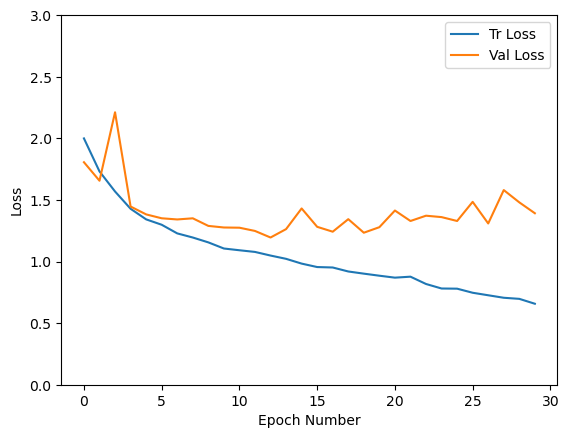

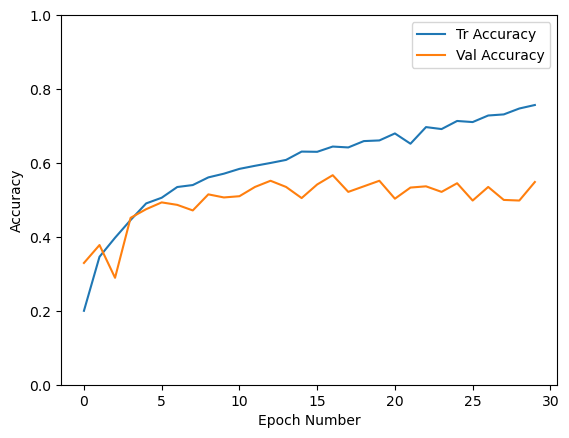

Test Batch number: 000, Test: Loss: 1.3117, Accuracy: 0.5938
Test Batch number: 001, Test: Loss: 1.3352, Accuracy: 0.4688
Test Batch number: 002, Test: Loss: 0.9616, Accuracy: 0.6562
Test Batch number: 003, Test: Loss: 0.8826, Accuracy: 0.6875
Test Batch number: 004, Test: Loss: 1.6912, Accuracy: 0.4375
Test Batch number: 005, Test: Loss: 0.9543, Accuracy: 0.5312
Test Batch number: 006, Test: Loss: 0.8819, Accuracy: 0.6562
Test Batch number: 007, Test: Loss: 0.9810, Accuracy: 0.6562
Test Batch number: 008, Test: Loss: 1.1155, Accuracy: 0.6562
Test Batch number: 009, Test: Loss: 1.0410, Accuracy: 0.6250
Test Batch number: 010, Test: Loss: 1.0531, Accuracy: 0.6562
Test Batch number: 011, Test: Loss: 1.3940, Accuracy: 0.4688
Test Batch number: 012, Test: Loss: 1.0176, Accuracy: 0.5938
Test Batch number: 013, Test: Loss: 1.3313, Accuracy: 0.5625
Test Batch number: 014, Test: Loss: 1.2109, Accuracy: 0.6250
Test Batch number: 015, Test: Loss: 1.3212, Accuracy: 0.5625
Test Batch number: 016, 

<Figure size 640x480 with 0 Axes>

In [116]:

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract)

if model_name != 'vgg':
    set_parameter_requires_gradTrue(model_ft)
         
# Device used to train the network (Ex: GPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

# Send the model to the processing unit
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

curr_time = datetime.now().strftime("%Y%m%d_%H%M%S")
history_path = os.path.join('./history/', curr_time)

os.mkdir(history_path)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_model, history, best_epoch = train_and_validate(model_ft, criterion, optimizer_ft, epochs=num_epochs)

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.savefig(os.path.join(history_path, 'loss_curve.png'))
plt.show()
plt.clf()

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(os.path.join(history_path, 'accuracy_curve.png'))
plt.show()

def computeTestSetAccuracy(loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''
    # model = torch.load(os.path.join(history_path, "model.pt"))
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    confusion_matrix = torch.zeros(num_classes, num_classes)

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        model = best_model
        
        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.type(torch.FloatTensor).to(device)
            labels = labels.to(device)

            # labels.cpu().numpy()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Confusion matrix
            for t, p in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            log = "Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item())
            print(log)
            
            with open(os.path.join(history_path, 'test.log'), 'a') as the_file:
                the_file.write(log + '\n')

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    cm = confusion_matrix.cpu().numpy()
    plt.imshow(cm, cmap='gray_r')
    plt.colorbar()

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.0f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > (cm.max() / 1.5) else "black")

    tick_marks = np.arange(len(confusion_matrix))
    plt.xticks(tick_marks, idx_to_class.values(), rotation=45)
    plt.yticks(tick_marks, idx_to_class.values())

    plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(os.path.join(history_path, 'confusion_matrix.png'), bbox_inches="tight")

    plt.clf()

    indiv_acc = (confusion_matrix.diag()/confusion_matrix.sum(1)).numpy()

    print("Test Accuracy : " + str(avg_test_acc))

    print("Test Accuracy Per Class :")

    for key in idx_to_class:
        print(f"{idx_to_class[key]} - {round(indiv_acc[key] * 100, 4)}%")

    with open(os.path.join(history_path, 'test.log'), 'a') as the_file:
        the_file.write("Test Accuracy : " + str(avg_test_acc) + "\n\n")
        the_file.write("Test Accuracy Per Class : \n")
        for key in idx_to_class:
            the_file.write(f"{idx_to_class[key]} - {round(indiv_acc[key] * 100, 4)}%\n")

computeTestSetAccuracy(criterion)
